# Assignment 2

In this assignment, you will be working on an image classification task (codename `pnp`) using the transfer learning technique.
The task objective is to determine whether an image contains a person (`pnp` stands for person / non-person) -- a binary classification task.

## Dataset
* Dataset contains 80K images with known labels (for model development), and 20K images with unknown labels (for scoring).
* Dataset has been created from a subset of COCO Dataset, and so all copyrights belong to the original authors: https://cocodataset.org/#termsofuse
* Images have been rescaled and padded to be of shape (224, 224, 3).

While it's possible to create a new model architecture and train a model specifically for this task, that would be expensive in terms of time and cloud resources.
Instead, in this assignment, you will be re-using an pre-trained model's architecture and parameters to save time and cloud resources.

## MobileNet Architecture
* The pre-trained model's name is MobileNetV2: https://arxiv.org/pdf/1801.04381.pdf
* MobileNet is a relatively small network that is designed for usage on mobile devices with limited compute and storage resource.
* It's a great choice for this assignment, since this network can be relatively quickly processed with a single GPU.

## MobileNet Parameters
* Keras provides network architecture and pre-trained parameters: https://keras.io/api/applications/mobilenet/#mobilenetv2-function
* The pre-trained parameters come from the ImageNet 1000-class task, which does not include a person label.
* The lower part of the network can be reused due to the shared hierarchy of visual information..


In [1]:
!ls pnp_dataset || (wget https://danylo-ucla.s3.us-west-2.amazonaws.com/pnp_dataset.zip && unzip pnp_dataset.zip >/dev/null 2>&1)

score_x  train_x  train_y.npy


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def load_images(folder: str):
    imgs = []

    paths = !find {folder} -type f
    paths = sorted(paths)

    for path in paths:
        with open(path, 'r') as f:
            imgs.append(plt.imread(path))
            
    return np.array(imgs)

In [3]:
train_x = load_images('pnp_dataset/train_x')
score_x = load_images('pnp_dataset/score_x')
train_y = np.load('pnp_dataset/train_y.npy')

In [4]:
train_x.shape, train_y.shape

((80000, 224, 224, 3), (80000,))

In [5]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.20, random_state=42)

In [6]:
train_y[:5]

array([0, 1, 1, 1, 1])

0

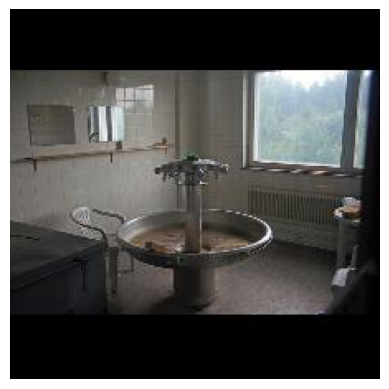

In [7]:
plt.imshow(train_x[0])
plt.axis('off')
train_y[0]

1

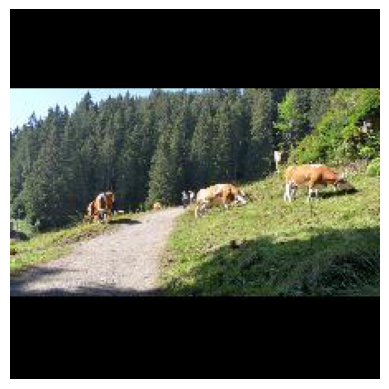

In [8]:
plt.imshow(train_x[1])
plt.axis('off')
train_y[1]

In [9]:
# This configures the GPU to be used by Tensorflow.

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2022-10-05 22:56:42.704409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 22:56:42.757149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 22:56:42.758024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [23]:
# https://arxiv.org/pdf/1801.04381.pdf
# https://keras.io/api/applications/mobilenet/#mobilenetv2-function
mobile_net = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling="avg",
    weights="imagenet"
)

In [24]:
# Freezes the parameters of the MobileNet layers, so they will not update during training.
# These parameters are initialized to a pre-trained snapshot using the ImagetNet dataset.
mobile_net.trainable = False

In [12]:
# mobile_net.summary()

In [25]:
model = tf.keras.models.Sequential([
    mobile_net,
    tf.keras.layers.Dropout(rate=0.05),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dropout(rate=0.05),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                81984     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,340,033
Trainable params: 82,049
Non-trainable params: 2,257,984
_______________________________________

In [27]:
model.compile(
    optimizer="adam",
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ]
)
batch_size = 128

In [16]:
with tf.device('/CPU:0'):
    train_x = tf.constant(train_x)
    train_y = tf.constant(train_y)
    test_x = tf.constant(test_x)
    test_y = tf.constant(test_y)
    score_x = tf.constant(score_x)

2022-10-05 22:56:44.894108: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9633792000 exceeds 10% of free system memory.


In [28]:
import numpy as np
import tensorflow as tf
np.random.seed(11)
tf.random.set_seed(11)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(
    train_x,
    train_y,
    epochs=16,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.25,
    callbacks=[stop_early]
)

2022-10-05 23:07:38.369552: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7225344000 exceeds 10% of free system memory.


Epoch 1/16
375/375 [==============================] - 142s 372ms/step - loss: 0.6483 - binary_accuracy: 0.6179 - val_loss: 0.6118 - val_binary_accuracy: 0.6606
Epoch 2/16
375/375 [==============================] - 137s 365ms/step - loss: 0.6217 - binary_accuracy: 0.6500 - val_loss: 0.5992 - val_binary_accuracy: 0.6756
Epoch 3/16
375/375 [==============================] - 137s 365ms/step - loss: 0.6106 - binary_accuracy: 0.6623 - val_loss: 0.5926 - val_binary_accuracy: 0.6844
Epoch 4/16
375/375 [==============================] - 137s 365ms/step - loss: 0.6040 - binary_accuracy: 0.6705 - val_loss: 0.5899 - val_binary_accuracy: 0.6826
Epoch 5/16
375/375 [==============================] - 137s 365ms/step - loss: 0.5991 - binary_accuracy: 0.6749 - val_loss: 0.5882 - val_binary_accuracy: 0.6749
Epoch 6/16
375/375 [==============================] - 137s 366ms/step - loss: 0.5969 - binary_accuracy: 0.6750 - val_loss: 0.5834 - val_binary_accuracy: 0.6924
Epoch 7/16
375/375 [====================

In [18]:
len(mobile_net.layers)

155

In [29]:
mobile_net.trainable = True
for layer in mobile_net.layers[:150]:
      layer.trainable =  False
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                81984     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,340,033
Trainable params: 494,849
Non-trainable params: 1,845,184
______________________________________

In [30]:
model.compile(
    optimizer="adam",
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ]
)
batch_size = 128

In [32]:
import numpy as np
import tensorflow as tf
np.random.seed(11)
tf.random.set_seed(11)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(
    train_x,
    train_y,
    epochs=8,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.25,
    callbacks=[stop_early]
)

Epoch 1/8
375/375 [==============================] - 142s 378ms/step - loss: 0.5062 - binary_accuracy: 0.7424 - val_loss: 0.5753 - val_binary_accuracy: 0.7091
Epoch 2/8
375/375 [==============================] - 142s 378ms/step - loss: 0.4931 - binary_accuracy: 0.7483 - val_loss: 0.5748 - val_binary_accuracy: 0.7060
Epoch 3/8
375/375 [==============================] - 141s 378ms/step - loss: 0.4801 - binary_accuracy: 0.7563 - val_loss: 0.5629 - val_binary_accuracy: 0.7156
Epoch 4/8
375/375 [==============================] - 141s 377ms/step - loss: 0.4670 - binary_accuracy: 0.7662 - val_loss: 0.5716 - val_binary_accuracy: 0.7202
Epoch 5/8
375/375 [==============================] - 141s 377ms/step - loss: 0.4783 - binary_accuracy: 0.7595 - val_loss: 0.5561 - val_binary_accuracy: 0.7167
Epoch 6/8
375/375 [==============================] - 141s 377ms/step - loss: 0.4672 - binary_accuracy: 0.7656 - val_loss: 0.5782 - val_binary_accuracy: 0.7205
Epoch 7/8
375/375 [===========================

In [33]:
from sklearn.metrics import accuracy_score
train_predicted = model.predict(train_x, batch_size=batch_size)
accuracy_score(train_y, np.where(train_predicted >= 0.5, 1, 0))

In [37]:
test_predicted = model.predict(test_x, batch_size=batch_size)
accuracy_score(test_y, np.where(test_predicted >= 0.5, 1, 0))

0.715

In [38]:
import os 
import pandas as pd

model_dir = 'pnp_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the model on the score dataset.
score_y_hat = pd.DataFrame(
    model.predict(score_x, batch_size=batch_size),
    # This is needed to save the file in Parquet format.
    columns=['score']
)

# Now save it to disc as a Parquet file.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    f.write(json.dumps(json.loads(model.to_json()), indent=True))

# Finally, let's save the learned parameters.
model.save_weights(f'{model_dir}/keras_parameters.h5')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. keras_model.json -- the model's definition
# 3. keras_parameters.json -- the model's trained parameters
# 4. score_y_hat.parquet - the model's output on the score dataset